In [1]:
import numpy as np
import pandas as pd
import iex_api as iex
import capdata as capdata
import plotting as plots
import beta_maker as beta 
import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
import scipy.stats as scs
import fbprophet as fbprophet
%matplotlib inline


In [2]:
endpoint = 'https://api.iextrading.com/1.0/stock/market/batch'
FAANG_symbols = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL']
start_date = pd.to_datetime('04-04-2014')


shares_dicts = capdata.shares_dictionaries(FAANG_symbols)

FAANG_dfs = capdata.market_cap_data(capdata.filter_dates(iex.historical_prices([(', ').join(FAANG_symbols)],\
                                                                    '5y', endpoint), start_date), shares_dicts)
SPY_df = capdata.filter_dates(iex.historical_prices(['SPY'], '5y', endpoint), start_date)

SP_cap_df = capdata.SP_data('data/daily/SP500MarketCap.csv', start_date)

cap_df = capdata.df_compiler(FAANG_dfs, FAANG_symbols, 'cap')
close_df = capdata.df_compiler(FAANG_dfs, FAANG_symbols, 'close')

Request successful
Request successful


# Distribution of Returns

## KS test of equality 

In [4]:
SPY_returns = beta.returns_maker(SPY_df['SPY'], 'log').rename(columns={'close':'Change'})

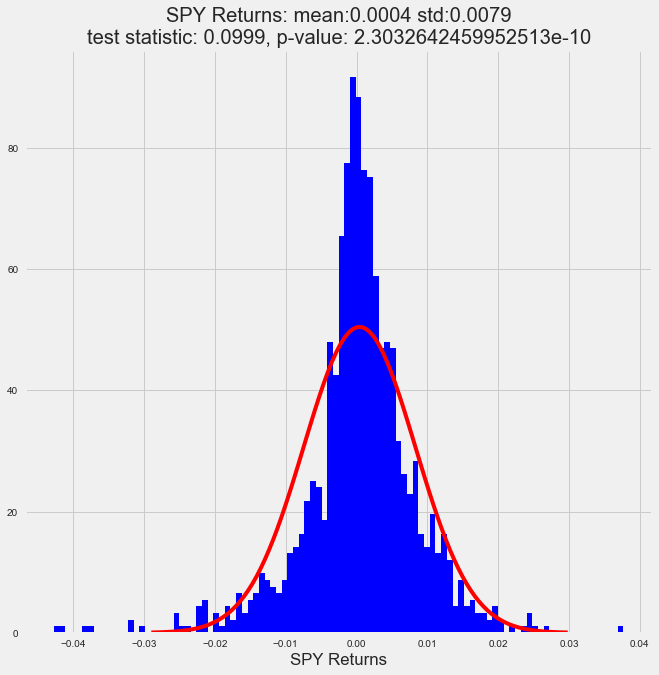

In [5]:
plt.style.use('fivethirtyeight')
KS_norm_p = plots.plot_histogram_with_dist('SPY', SPY_returns['Change'], 'norm')

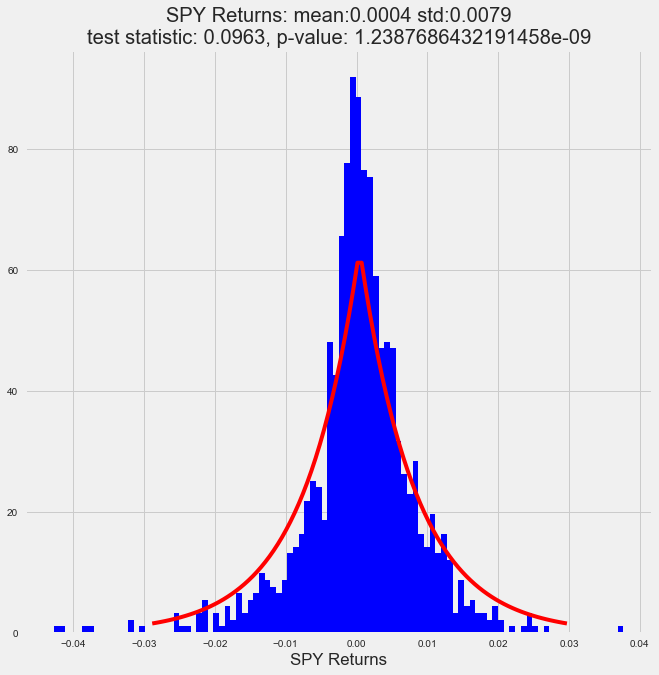

In [10]:
KS_laplace_p = plots.plot_histogram_with_dist('SPY', SPY_returns['Change'], 'laplace')

# Total Returns 

In [7]:
returns_df = close_df.pct_change().dropna()
def total_return_from_returns(returns):
    return ((returns + 1).prod() - 1) * 100 
total_return_from_returns(returns_df)

AAPL     215.545118
AMZN     453.749226
FB       170.912263
GOOGL    105.509399
NFLX     604.669922
dtype: float64

# Beta

\begin{equation*}
x = cov(market, stock) / var(market)
\end{equation*}

In [12]:
FAANG_dict = dict(zip(close_df.columns, [close_df[col] for col in close_df]))
rolling_betas = beta.beta_maker(FAANG_dict, SPY_df, 'monthly', 36)
rolling_betas.iloc[-1,:]

AAPL     1.282808
AMZN     1.701540
FB       0.578188
GOOGL    1.296484
NFLX     1.554624
Name: (2018, 10), dtype: float64

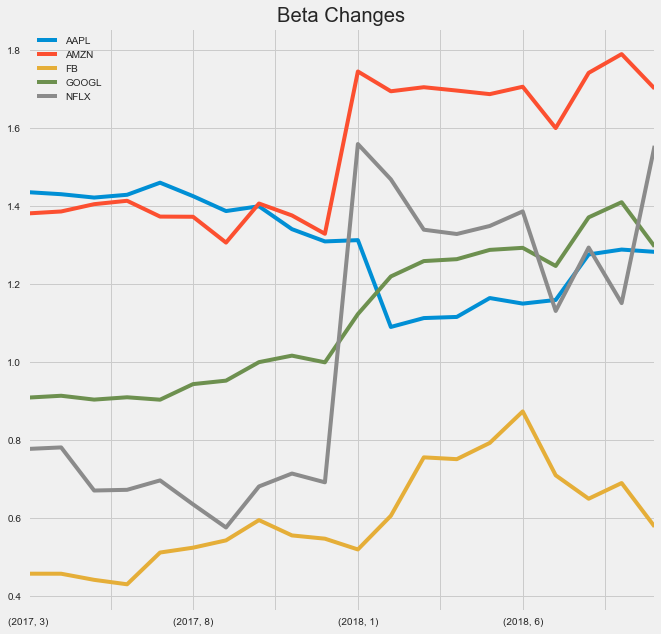

In [13]:
rolling_betas.plot(figsize=(10,10))
plt.title('Beta Changes');

# Correlation Matrix of Stock Returns

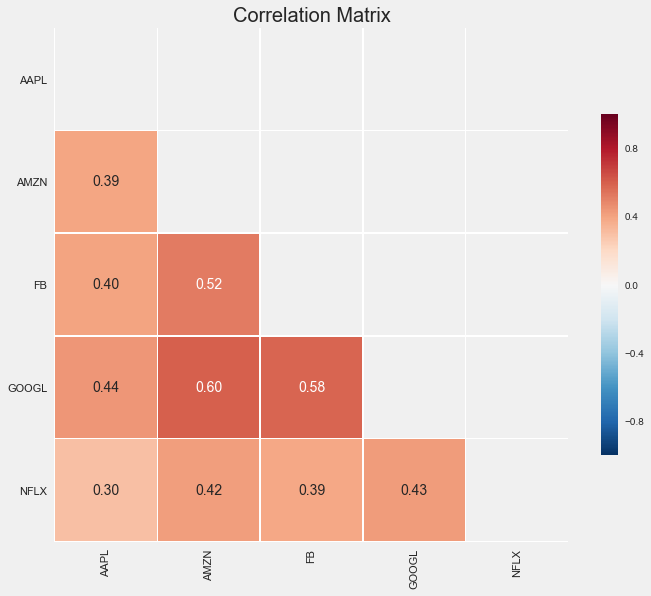

In [14]:
plots.corr_heatmap_with_values(beta.returns_maker(close_df))

# Cumulative Returns 

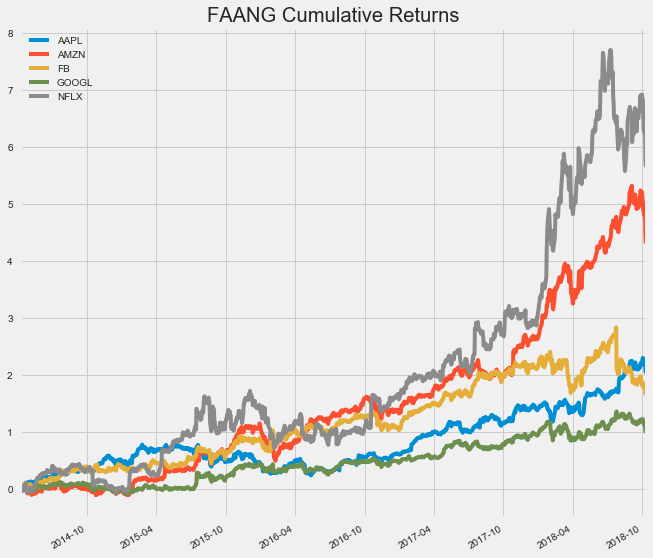

In [17]:
((beta.returns_maker(close_df) + 1).cumprod()-1).plot(figsize=(10,10), title='FAANG Cumulative Returns');

# Market Cap Changes 

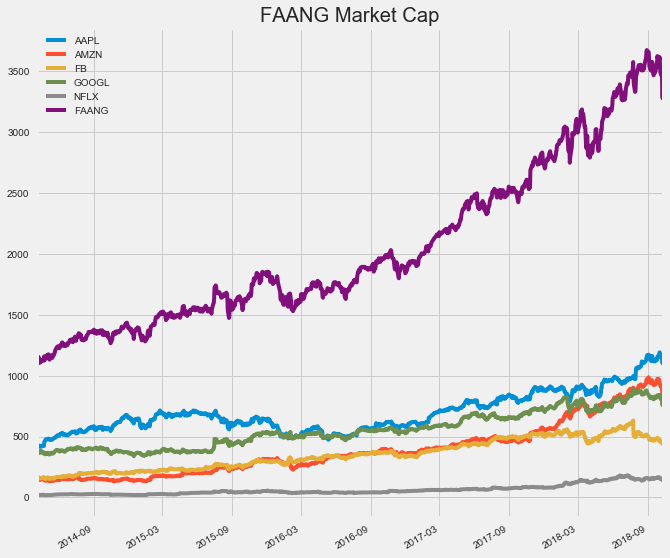

In [18]:
cap_df['FAANG'] = cap_df.sum(axis=1)
cap_df.plot(figsize=(10,10), title='FAANG Market Cap')

In [20]:
sp_cap = pd.read_csv('data/spcap.csv')

In [21]:
sp_cap['Date'] = sp_cap['Date'].apply(pd.to_datetime)
sp_cap = pd.DataFrame(columns=['Cap'], data= sp_cap['Cap'].values, index=sp_cap['Date'])

In [22]:
cap_df['SP'] = (sp_cap*1000).reindex(cap_df.index)
cap_df = cap_df[cap_df.index >= pd.to_datetime('8-1-2014')]
cap_df = cap_df.fillna(method='backfill')

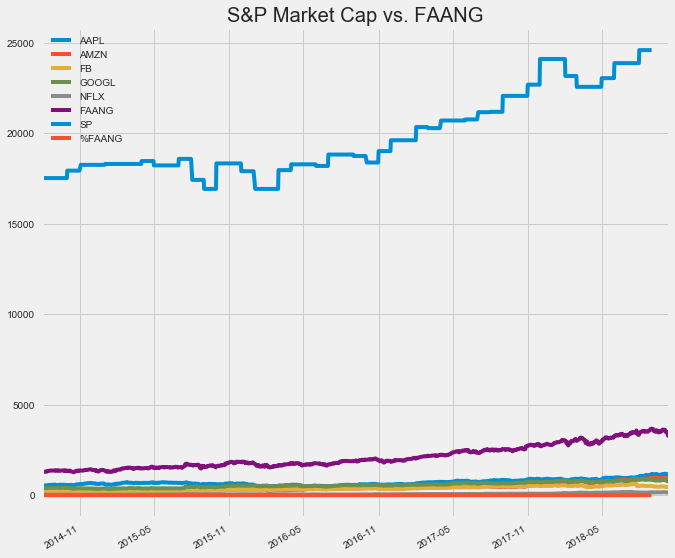

In [26]:
cap_df.plot(figsize=(10,10), title='S&P Market Cap vs. FAANG')

In [24]:
cap_df['%FAANG'] = cap_df['FAANG']/cap_df['SP']

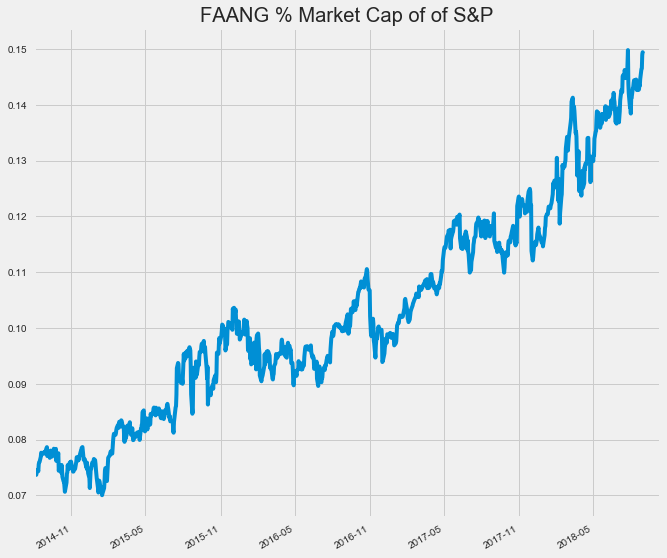

In [25]:
cap_df['%FAANG'].plot(figsize=(10,10), title='FAANG % Market Cap of of S&P');

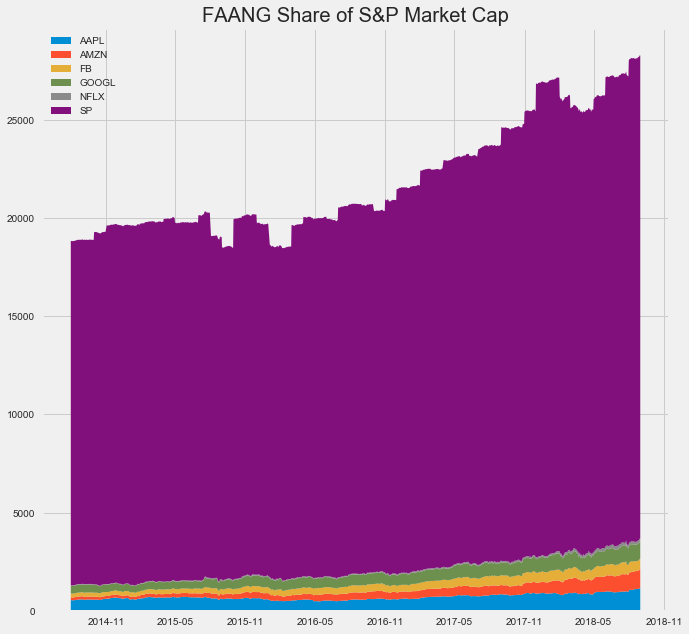

In [27]:
f_caps = cap_df.drop(['FAANG','%FAANG'], axis=1).dropna()
caps = [f_caps[col] for col in f_caps.columns]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.stackplot(f_caps.index, caps, labels=f_caps.columns)
ax.set_title('FAANG Share of S&P Market Cap')
plt.legend(loc=2)

# Forecasts of FAANG stocks and S&P

In [367]:
def fb_forecaster(cap_df, symbol):
    final_df = cap_df[symbol].reset_index()
    final_df = final_df.rename(columns={'index': 'ds', symbol: 'y'})
    stock_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, daily_seasonality=True)
    stock_prophet.fit(final_df)
    stock_forecast = stock_prophet.make_future_dataframe(periods=365 * 5, freq='D')
    stock_forecast = stock_prophet.predict(stock_forecast)
    
    return stock_prophet, stock_forecast 

fb_prophet, fb_forecast = fb_forecaster(f_caps, 'FB')

amzn_prophet, amzn_forecast = fb_forecaster(f_caps, 'AMZN')

aapl_prophet, aapl_forecast = fb_forecaster(f_caps, 'AAPL')

nflx_prophet, nflx_forecast = fb_forecaster(f_caps, 'NFLX')

googl_prophet, googl_forecast = fb_forecaster(f_caps, 'GOOGL')

sp_prophet, sp_forecast = fb_forecaster(f_caps, 'SP')

/Users/kevinkaltenbacher/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


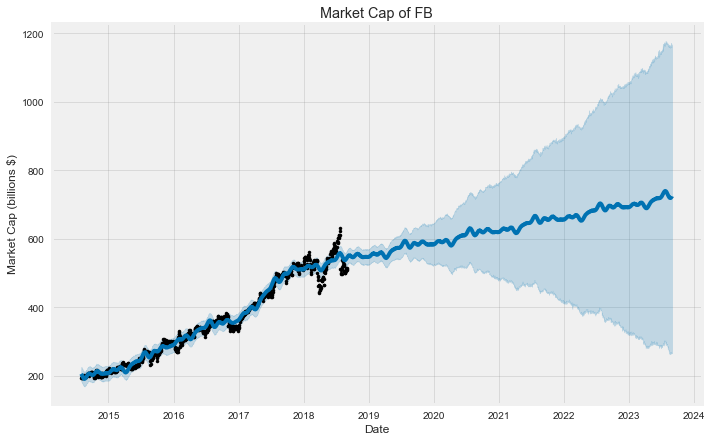

In [360]:
fb_prophet.plot(fb_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of FB');

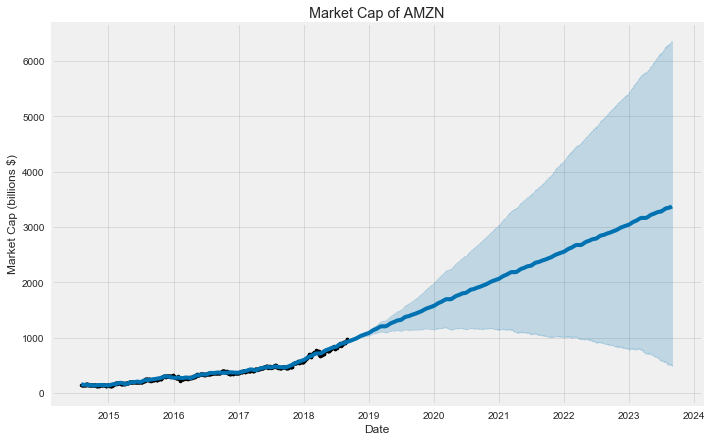

In [362]:
amzn_prophet.plot(amzn_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of AMZN');

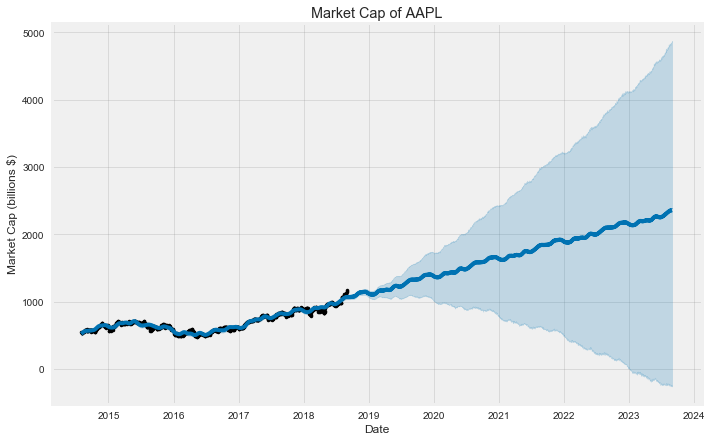

In [363]:
aapl_prophet.plot(aapl_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of AAPL');

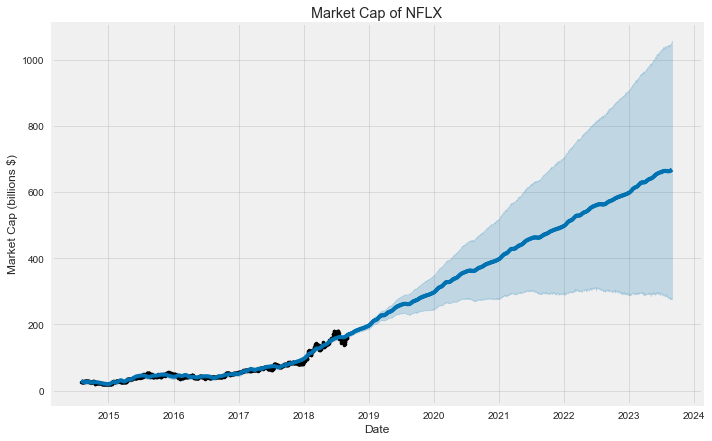

In [364]:
nflx_prophet.plot(nflx_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of NFLX');

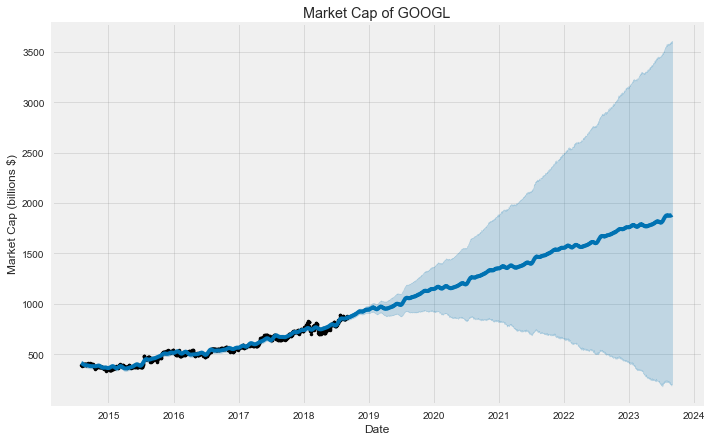

In [365]:
googl_prophet.plot(googl_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GOOGL');

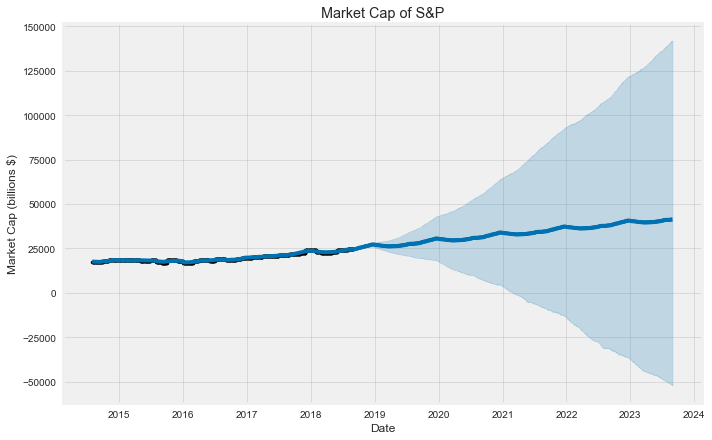

In [369]:
sp_prophet.plot(sp_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of S&P');

In [380]:
trends = [df['trend'].values for df in forecast_list]

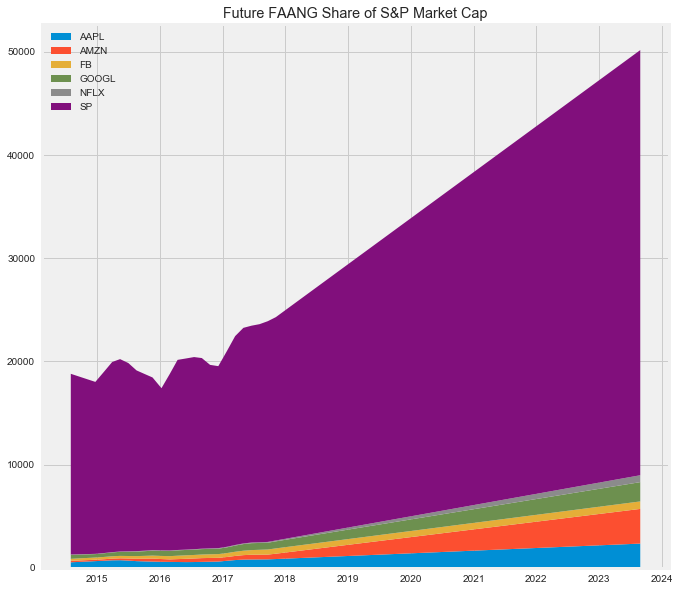

In [418]:
forecast_list = [fb_forecast, amzn_forecast, aapl_forecast, nflx_forecast, googl_forecast, sp_forecast]
f_cols = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL', 'SP']
f_trends = pd.DataFrame(dict(zip(f_cols, [df['trend'] for df in forecast_list])))
f_trends = f_trends.set_index(fb_forecast['ds'])
trends_list = [f_trends[symbol] for symbol in f_trends.columns]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.stackplot(f_trends.index, trends_list, labels=f_trends.columns)
ax.set_title('Future FAANG Share of S&P Market Cap')
plt.legend(loc=2);
# plt.tight_layout()

In [426]:
f_trends['FAANG'] = f_trends.drop('SP', axis=1).sum(axis=1)

In [429]:
f_trends['%FAANG'] = f_trends['FAANG']/f_trends['SP']

In [433]:
f_trends['%FAANG'][-1]

0.21770101229635822